In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# For explainability
import warnings
warnings.filterwarnings('ignore')

# 1. LOAD DATA
# The dataset uses '?' for missing values, we must flag this during load
try:
    # Assuming the file is in the same directory.
    # specific encoding might be needed if standard utf-8 fails, but usually fine for this dataset.
    df = pd.read_csv('/content/drive/MyDrive/hackathon_svpcet/student_learning_dataset.csv', na_values=['?'])
    print(f"Dataset Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please ensure 'student_learning_dataset.csv' is in the directory.")
    # Creating dummy data for demonstration if file doesn't exist (FOR USER TO TEST CODE)
    # UNCOMMENT THE CODE BELOW IF YOU WANT TO TEST WITHOUT THE REAL FILE
    # df = pd.DataFrame({
    #     'id_student': np.random.randint(1000, 2000, 100),
    #     'gender': np.random.choice(['M', 'F'], 100),
    #     'final_result': np.random.choice(['Pass', 'Fail', 'Distinction', 'Withdrawn'], 100),
    #     'total_clicks': np.random.randint(0, 500, 100),
    #     'score': np.random.randint(0, 100, 100)
    # })

# 2. INITIAL CLEANING
print("Missing Values per column:\n", df.isnull().sum())

# Drop columns with excessive missing data (like date_unregistration for passing students)
# We keep rows even if some assessment scores are missing, filling them with 0 (assuming submission missed)
df['score'] = df['score'].fillna(0)

# Convert columns to numeric if they were read as objects due to '?'
cols_to_numeric = ['score', 'date', 'weight', 'total_clicks']
for col in cols_to_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

display(df.head())

Dataset Loaded Successfully. Shape: (180662, 24)
Missing Values per column:
 code_module                    0
code_presentation              0
id_student                     0
gender                         0
region                         0
highest_education              0
imd_band                    7810
age_band                       0
num_of_prev_attempts           0
studied_credits                0
disability                     0
final_result                   0
date_registration             48
date_unregistration       162208
id_assessment               6750
date_submitted              6750
is_banked                   6750
score                       6923
assessment_type             6750
date                        9615
weight                      6750
total_clicks                3483
avg_clicks                  3483
total_vle_interactions      3483
dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,id_assessment,date_submitted,is_banked,score,assessment_type,date,weight,total_clicks,avg_clicks,total_vle_interactions
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,1752.0,18.0,0.0,78.0,TMA,19.0,10.0,934.0,4.765306,196.0
1,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,1753.0,53.0,0.0,85.0,TMA,54.0,20.0,934.0,4.765306,196.0
2,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,1754.0,115.0,0.0,80.0,TMA,117.0,20.0,934.0,4.765306,196.0
3,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,1755.0,164.0,0.0,85.0,TMA,166.0,20.0,934.0,4.765306,196.0
4,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,1756.0,212.0,0.0,82.0,TMA,215.0,30.0,934.0,4.765306,196.0


Loading dataset...
Data Loaded. Shape: (180662, 24)
Aggregating data to student level...
Column names sanitized for XGBoost.


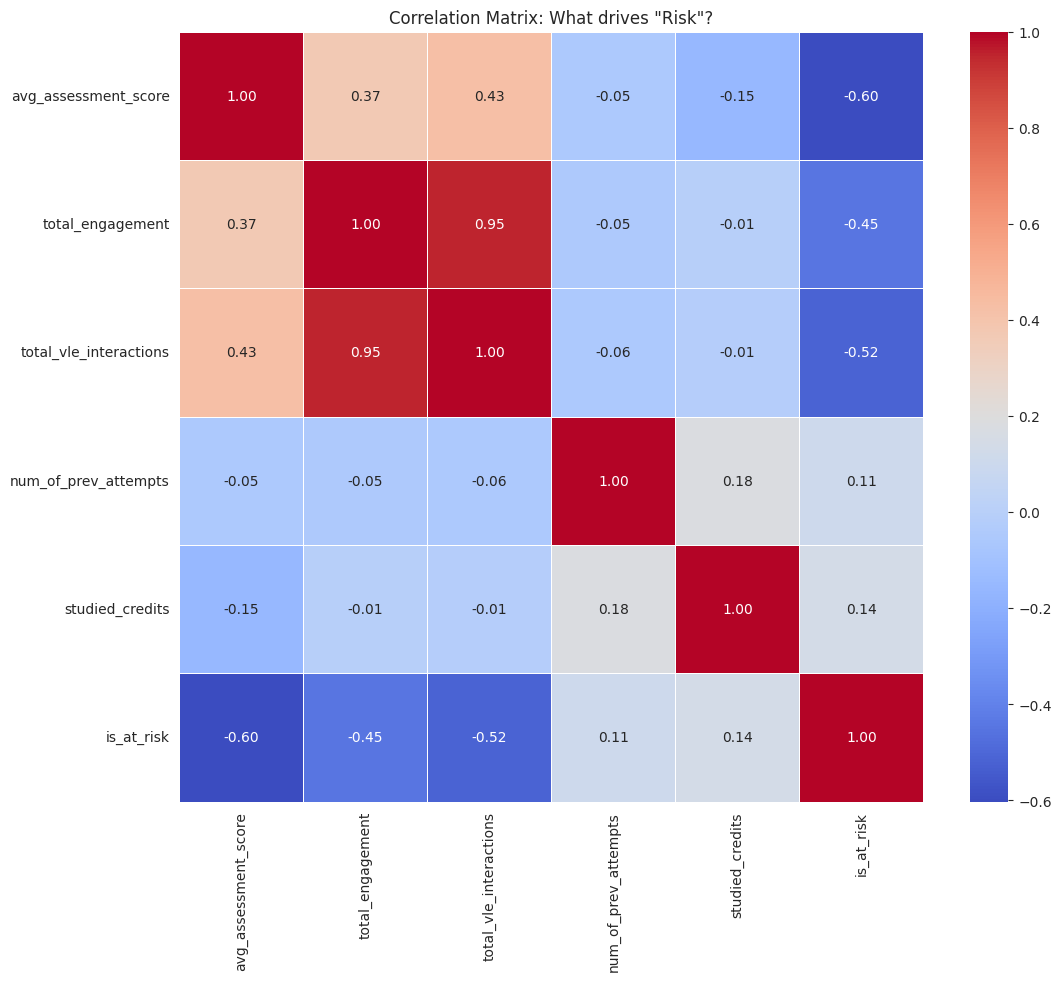

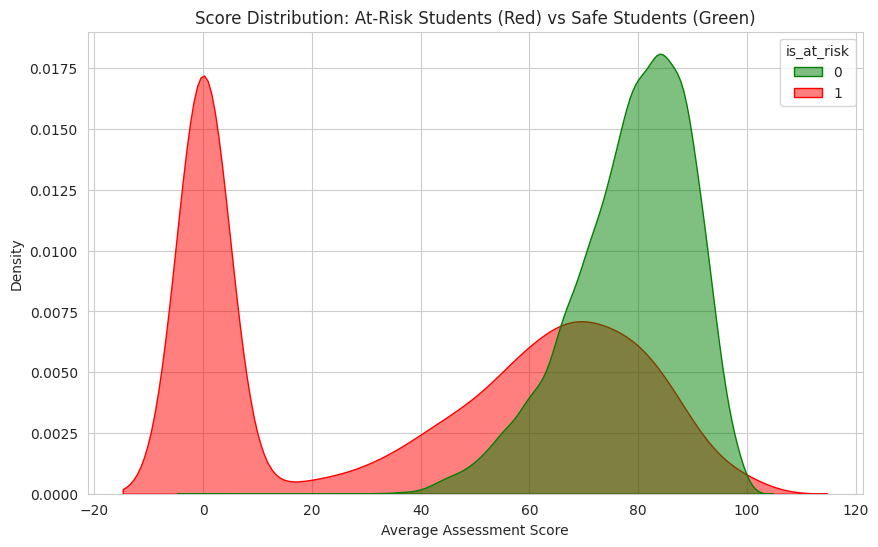

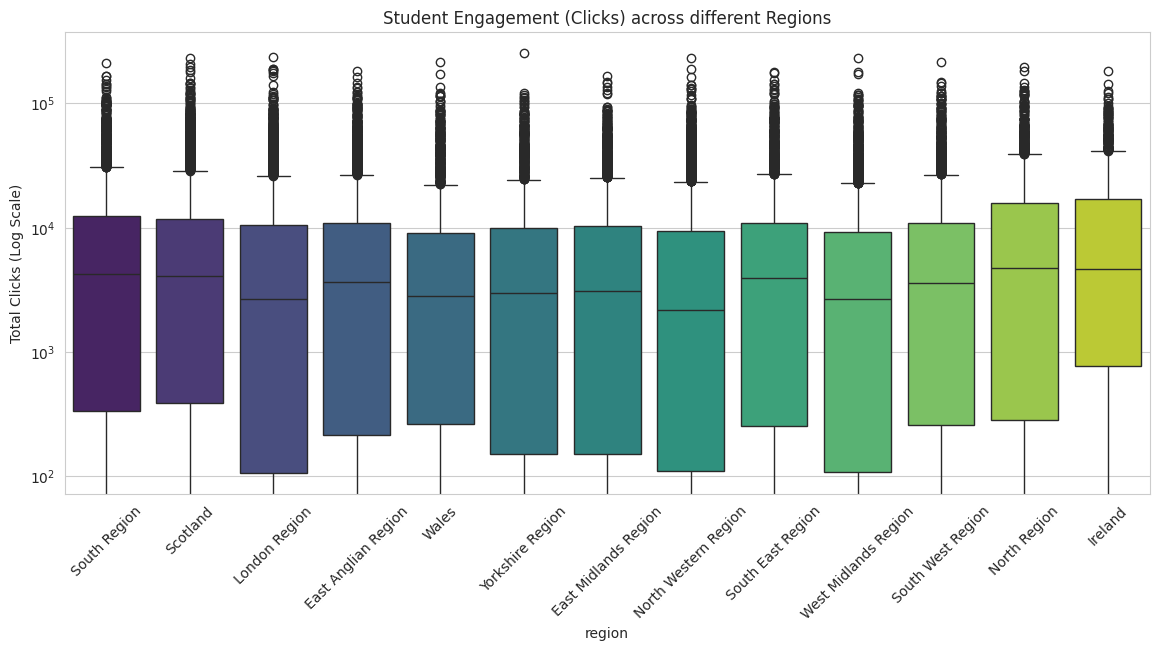

Training XGBoost Model...


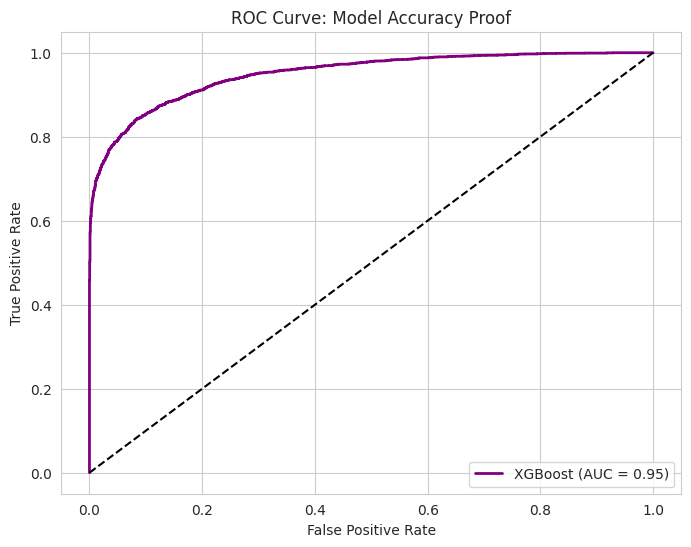

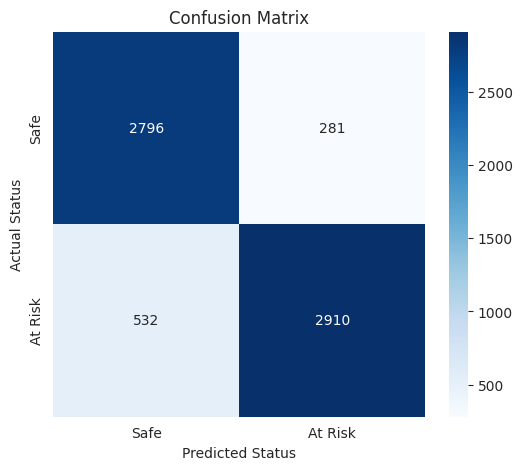

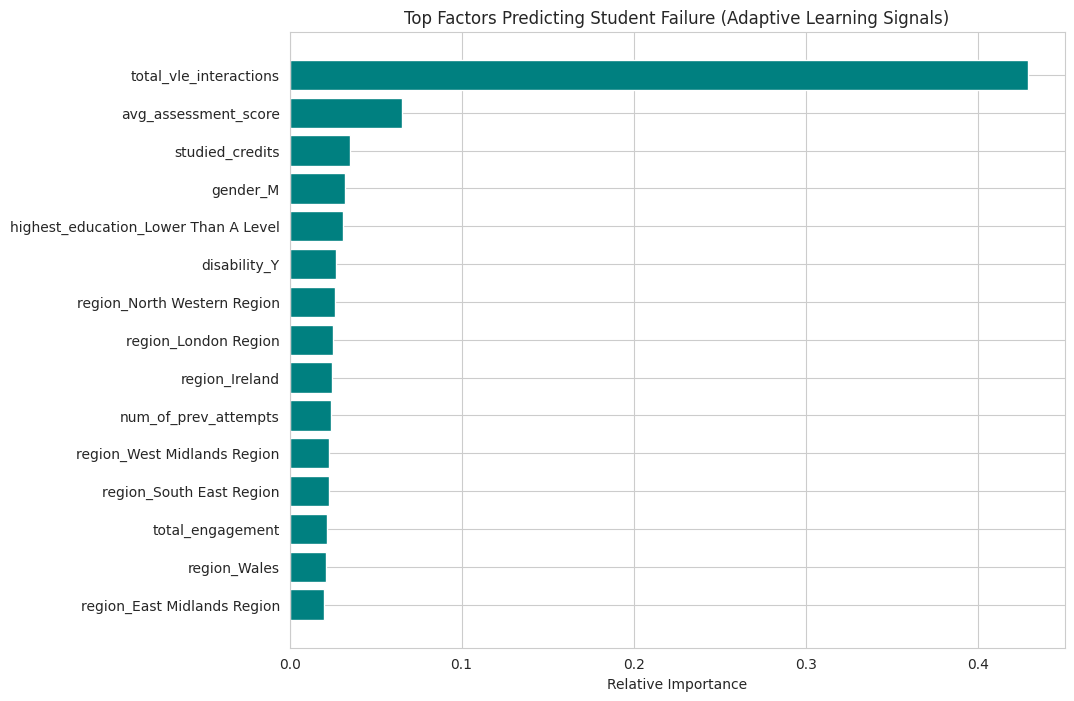

All visualizations generated successfully.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  # Standard library for Regex (Crucial for the fix)

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Set visual style
sns.set_style("whitegrid")

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
print("Loading dataset...")
# Load data handling '?' as NaN immediately
df = pd.read_csv('/content/drive/MyDrive/hackathon_svpcet/student_learning_dataset.csv', na_values=['?'])

# Quick Clean: Fill missing scores with 0 (assuming non-submission)
df['score'] = df['score'].fillna(0)

# Ensure numeric types
cols_to_numeric = ['score', 'weight', 'total_clicks', 'total_vle_interactions']
for col in cols_to_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print(f"Data Loaded. Shape: {df.shape}")

# ==========================================
# 2. FEATURE ENGINEERING (AGGREGATION)
# ==========================================
# We must aggregate multiple rows per student into ONE row per student.

agg_dict = {
    'score': 'mean',                   # Average score across assessments
    'total_clicks': 'sum',             # Total engagement
    'total_vle_interactions': 'sum',   # Total VLE interactions
    'studied_credits': 'first',        # Static value
    'num_of_prev_attempts': 'first'    # Static value
}

# Add categorical columns to aggregation (taking the first occurring value)
cat_cols = ['gender', 'region', 'highest_education', 'age_band', 'disability', 'final_result']
for col in cat_cols:
    if col in df.columns:
        agg_dict[col] = 'first'

# Grouping
print("Aggregating data to student level...")
student_df = df.groupby(['id_student', 'code_module', 'code_presentation']).agg(agg_dict).reset_index()
student_df.rename(columns={'score': 'avg_assessment_score', 'total_clicks': 'total_engagement'}, inplace=True)

# Target Creation: 1 = At Risk (Fail/Withdraw), 0 = Safe (Pass/Distinction)
target_map = {'Withdrawn': 1, 'Fail': 1, 'Pass': 0, 'Distinction': 0}
student_df['is_at_risk'] = student_df['final_result'].map(target_map)
student_df.dropna(subset=['is_at_risk'], inplace=True)

# ==========================================
# 3. PREPROCESSING & THE FIX
# ==========================================
# One-Hot Encoding
categorical_features = ['gender', 'region', 'highest_education', 'age_band', 'disability']
student_df_encoded = pd.get_dummies(student_df, columns=categorical_features, drop_first=True)

# --- THE FIX FOR YOUR ERROR ---
# XGBoost does not allow [, ], or < in feature names. We use Regex to clean them.
regex = re.compile(r"[\[\]<]", re.IGNORECASE)
student_df_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in student_df_encoded.columns]
print("Column names sanitized for XGBoost.")

# Split Data
X = student_df_encoded.drop(['id_student', 'code_module', 'code_presentation', 'final_result', 'is_at_risk'], axis=1)
y = student_df_encoded['is_at_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 4. ADVANCED VISUALIZATIONS (EDA)
# ==========================================

# VISUAL 1: Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
# Select only numeric columns for clean correlation
numeric_cols = ['avg_assessment_score', 'total_engagement', 'total_vle_interactions', 'num_of_prev_attempts', 'studied_credits', 'is_at_risk']
corr = student_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: What drives "Risk"?')
plt.show()

# VISUAL 2: Distribution of Scores (Risk vs Safe)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=student_df, x='avg_assessment_score', hue='is_at_risk', fill=True, palette={0: 'green', 1: 'red'}, alpha=0.5)
plt.title('Score Distribution: At-Risk Students (Red) vs Safe Students (Green)')
plt.xlabel('Average Assessment Score')
plt.show()

# VISUAL 3: Engagement by Region
plt.figure(figsize=(14, 6))
sns.boxplot(data=student_df, x='region', y='total_engagement', palette='viridis')
plt.xticks(rotation=45)
plt.title('Student Engagement (Clicks) across different Regions')
plt.yscale('log') # Log scale handles outliers better
plt.ylabel('Total Clicks (Log Scale)')
plt.show()

# ==========================================
# 5. MODELING & EVALUATION
# ==========================================
print("Training XGBoost Model...")

# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train) # This will now work perfectly
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# VISUAL 4: ROC Curve (Model Performance Proof)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc_score = roc_auc_score(y_test, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})', color='purple', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model Accuracy Proof')
plt.legend(loc='lower right')
plt.show()

# VISUAL 5: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'At Risk'], yticklabels=['Safe', 'At Risk'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Status')
plt.xlabel('Predicted Status')
plt.show()

# VISUAL 6: Feature Importance (Explainability)
plt.figure(figsize=(10, 8))
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1][:15] # Top 15 features
plt.title('Top Factors Predicting Student Failure (Adaptive Learning Signals)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()
plt.show()

print("All visualizations generated successfully.")

In [3]:
print("Aggregating data to Student-Level...")

# We group by student ID and the specific course run (code_presentation)
# Strategy:
# - Take the MEAN of their assessment scores.
# - Take the SUM of their total clicks.
# - Keep static attributes (Gender, Region, Highest Ed, Final Result).

agg_dict = {
    'score': 'mean',
    'total_clicks': 'sum',
    'total_vle_interactions': 'sum',
    'studied_credits': 'first',
    'num_of_prev_attempts': 'first'
}

# Add categorical columns to 'first' strategy if they exist
cat_cols = ['gender', 'region', 'highest_education', 'age_band', 'disability', 'final_result']
for col in cat_cols:
    if col in df.columns:
        agg_dict[col] = 'first'

# Perform GroupBy
# Note: Adjust columns in groupby based on your exact CSV headers
group_cols = ['id_student', 'code_module', 'code_presentation']
student_df = df.groupby(group_cols).agg(agg_dict).reset_index()

# Rename columns for clarity
student_df.rename(columns={'score': 'avg_assessment_score', 'total_clicks': 'total_engagement'}, inplace=True)

print(f"New Student-Level Data Shape: {student_df.shape}")
display(student_df.head())

# --- TARGET ENGINEERING ---
# We want to predict "At Risk" vs "Safe".
# 'Withdrawn' and 'Fail' -> 1 (At Risk)
# 'Pass' and 'Distinction' -> 0 (Safe)

target_map = {
    'Withdrawn': 1,
    'Fail': 1,
    'Pass': 0,
    'Distinction': 0
}

student_df['is_at_risk'] = student_df['final_result'].map(target_map)

# Drop rows where final_result might have been unknown/nan
student_df.dropna(subset=['is_at_risk'], inplace=True)

print("Class Balance:\n", student_df['is_at_risk'].value_counts(normalize=True))

Aggregating data to Student-Level...
New Student-Level Data Shape: (32593, 14)


,id_student,code_module,code_presentation,avg_assessment_score,total_engagement,total_vle_interactions,studied_credits,num_of_prev_attempts,gender,region,highest_education,age_band,disability,final_result
0,3733,DDD,2013J,0.000000,0.0,0.0,60,0,M,South Region,HE Qualification,55<=,N,Withdrawn
1,6516,AAA,2014J,61.800000,13955.0,3310.0,60,0,M,Scotland,HE Qualification,55<=,N,Pass
2,8462,DDD,2013J,87.666667,1938.0,900.0,90,0,M,London Region,HE Qualification,55<=,N,Withdrawn
3,8462,DDD,2014J,86.500000,40.0,16.0,60,1,M,London Region,HE Qualification,55<=,N,Withdrawn
4,11391,AAA,2013J,82.000000,4670.0,980.0,240,0,M,East Anglian Region,HE Qualification,55<=,N,Pass


Class Balance:
 is_at_risk
1    0.527966
0    0.472034
Name: proportion, dtype: float64


In [9]:
import re # Essential for the fix

# 1. Preprocessing
# Encode Categorical Variables
categorical_features = ['gender', 'region', 'highest_education', 'age_band', 'disability']
# Ensure these columns exist before encoding
existing_cats = [c for c in categorical_features if c in student_df.columns]
student_df = pd.get_dummies(student_df, columns=existing_cats, drop_first=True)

# --- THE FIX: Sanitize Column Names for XGBoost ---
# This replaces symbols like '<', '[', or ']' with an underscore '_'
regex = re.compile(r"[\[\]<]", re.IGNORECASE)
student_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in student_df.columns]
print("Column names cleaned for XGBoost.")
# --------------------------------------------------

# Select Features and Target
X = student_df.drop(['id_student', 'code_module', 'code_presentation', 'final_result', 'is_at_risk'], axis=1)
y = student_df['is_at_risk']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Features (Important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- MODEL 1: Logistic Regression (Baseline) ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# --- MODEL 2: Random Forest (Ensemble) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# --- MODEL 3: XGBoost (Gradient Boosting) ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# This will now work because we removed the '<' symbol
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# --- COMPARISON FUNCTION ---
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} Results ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("-" * 30)

evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

Column names cleaned for XGBoost.
--- Logistic Regression Results ---
Accuracy: 0.8407731247123792
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3077
           1       0.86      0.83      0.85      3442

    accuracy                           0.84      6519
   macro avg       0.84      0.84      0.84      6519
weighted avg       0.84      0.84      0.84      6519

------------------------------
--- Random Forest Results ---
Accuracy: 0.8768215984046633
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3077
           1       0.91      0.85      0.88      3442

    accuracy                           0.88      6519
   macro avg       0.88      0.88      0.88      6519
weighted avg       0.88      0.88      0.88      6519

------------------------------
--- XGBoost Results ---
Accuracy: 0.8752876208007363
              precision    recall  f1-score   support

           0      

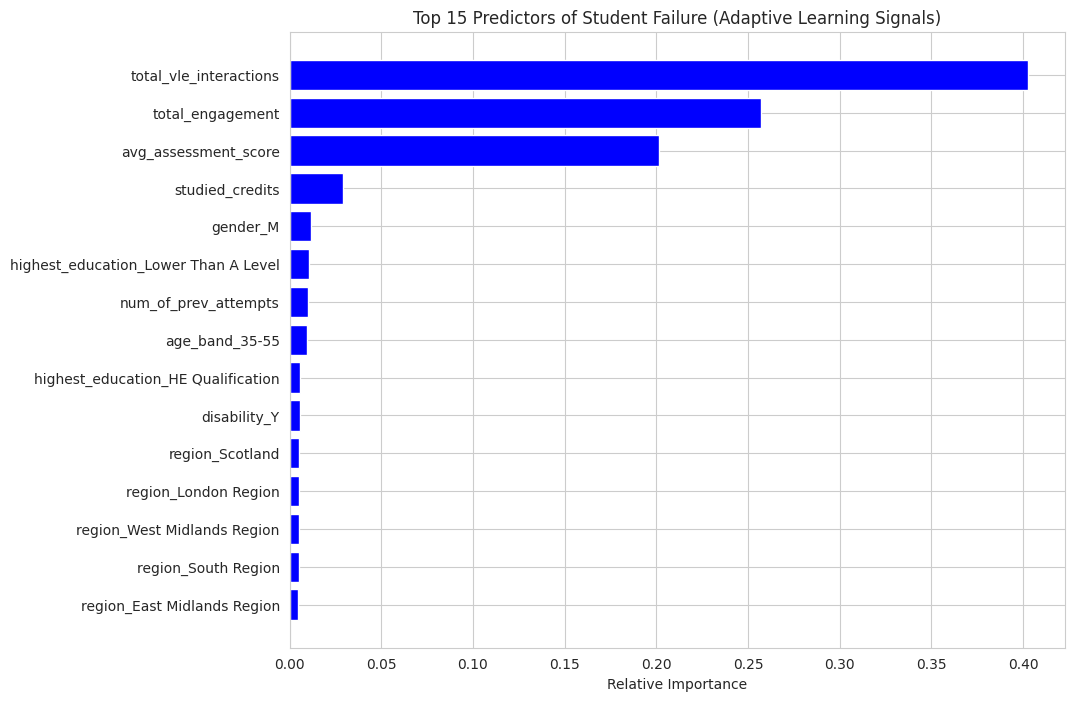

In [10]:
# Visualize Feature Importance from Random Forest
plt.figure(figsize=(10, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Top 15 features
top_indices = indices[:15]

plt.title('Top 15 Predictors of Student Failure (Adaptive Learning Signals)')
plt.barh(range(len(top_indices)), importances[top_indices], color='b', align='center')
plt.yticks(range(len(top_indices)), [X.columns[i] for i in top_indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()
plt.show()